# Brain Tumor Classification

In this notebook I will be working with the following [Brain Tumor Dataset](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection). It contains X-Ray images of brain divided into two categories: brains with cancer and healthy brains. My goal is to build Deep Learning classifier that learns to label brain X-Rays as either healthy or having a cancer.

I treat this exercise as a practice in building deep learning model with PyTorch framework. First, I will build a simple base model from scratch, then I will move to more sophisticated architectures, and utilize transfer learning to obtain the optimal performance.

## Imports

In [4]:
import os
import shutil

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
from torchinfo import summary

import numpy as np
import cv2
import imutils
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preprocessing

Before we start with any preprocessing steps, we will reorganize our files structure

In [5]:
# Original dataset path as downloaded from Kaggle
data_path = 'data/brain_tumor_dataset'
orig_dirs = [dir for dir in os.listdir(data_path)]

# New directories to be created
orig_imgs_dir = 'Original Data Set'
prep_imgs_dir = 'Preprocessed Data Set'

# Paths to new directories
orig_imgs_path = os.path.join(data_path, orig_imgs_dir)
prep_imgs_path = os.path.join(data_path, prep_imgs_dir)

# Create new directories
os.mkdir(orig_imgs_path)
os.mkdir(prep_imgs_path)

# Move original data set to the corresponding directory
for dir in orig_dirs:
    shutil.move(os.path.join(data_path, dir), orig_imgs_path)

In [6]:
# Create new directories for preprocessed images
prep_healthy_dir = 'prep no'
prep_tumor_dir = 'prep yes' 

prep_healthy_imgs_path = os.path.join(prep_imgs_path, prep_healthy_dir)
prep_tumor_imgs_path = os.path.join(prep_imgs_path, prep_tumor_dir)

os.mkdir(prep_healthy_imgs_path) 
os.mkdir(prep_tumor_imgs_path)

We will plot some of the images to get a general understanding of our dataset and decide if any preprocessing techniques should be applied. Let's define functions for loading and plotting.

In [7]:
def load_samples(data_path, num):
    """ Loads {num} sample images for each category. """
    imgs = []
    lbls = []
    
    for root, _, files in os.walk(data_path):
        for idx, filename in enumerate(files):
            filepath = root + os.sep + filename
            img = cv2.imread(filepath)
            imgs.append(img)
            label = root.split('\\')[-1]
            lbls.append(label)
            if idx+1 == num: break
            
    return imgs, lbls


def plot_samples(data_path, num=10):
    """ Plots {num} sample images for each category. """ 
    imgs, lbls = load_samples(data_path, num)
    ncols = 10
    nrows = int(2*num/ncols)

    plt.figure(figsize=(20, 10))
    for idx, (img, label) in enumerate(zip(imgs, lbls)):
        plt.subplot(nrows, ncols, idx + 1)
        plt.imshow(img)
        plt.xlabel(label)
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

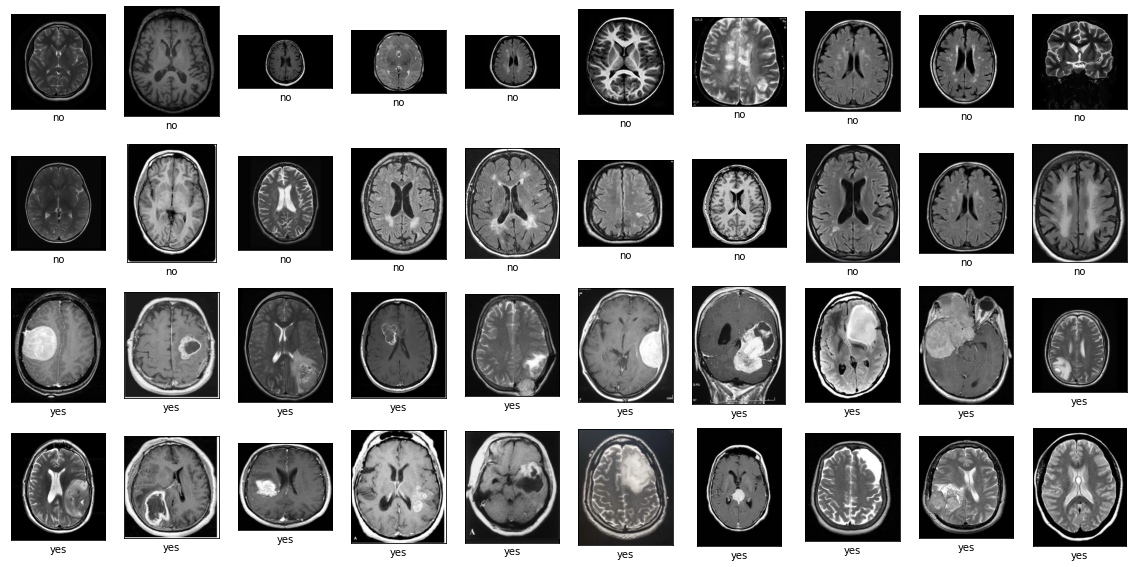

In [8]:
plot_samples(orig_imgs_path, 20)

As we can see, the images differ in width and heigth, we will handle this using transforms.Resize() later during Data Loading step. 
I want to crop the images, so that the dark background will be the maximum bounding rectangle of the actual brain image. This will normalize width/heigth ratios of the images.

In [9]:
def prep_images(data_path):
    for root, _, files in os.walk(data_path):
        label = root.split('\\')[-1]
        
        for filename in files:
            filepath = root + os.sep + filename
                
            img = cv2.imread(filepath)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            contrast = cv2.addWeighted(gray, 2, gray, 0, 0)
            blurred = cv2.GaussianBlur(contrast, (5, 5), 0)
            thresh = cv2.threshold(blurred, 55, 255, cv2.THRESH_BINARY)[1]

            # Perform closing operation 
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9, 9))
            closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

            # Find the biggest contour (brain contour)
            cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cnts = imutils.grab_contours(cnts)
            head_cnt = max(cnts, key = cv2.contourArea)

            # Create a mask
            mask = np.zeros_like(closed, dtype=np.uint8)
            cv2.drawContours(mask, [head_cnt], 0, 255, -1)
                
            # Crop the bounding rectangle of the head
            # contour
            (x, y, w, h) = cv2.boundingRect(head_cnt)
            head_img = img[y:y + h, x:x + w]

            filename = 'prep_{f}'.format(f=filename)
                
            # Save preprocessed image to the right directory,
            # depending on its label
            if label == orig_dirs[0]: 
                cv2.imwrite(os.path.join(prep_healthy_imgs_path, filename), head_img)
            else:
                cv2.imwrite(os.path.join(prep_tumor_imgs_path, filename), head_img)

In [10]:
prep_images(orig_imgs_path)  

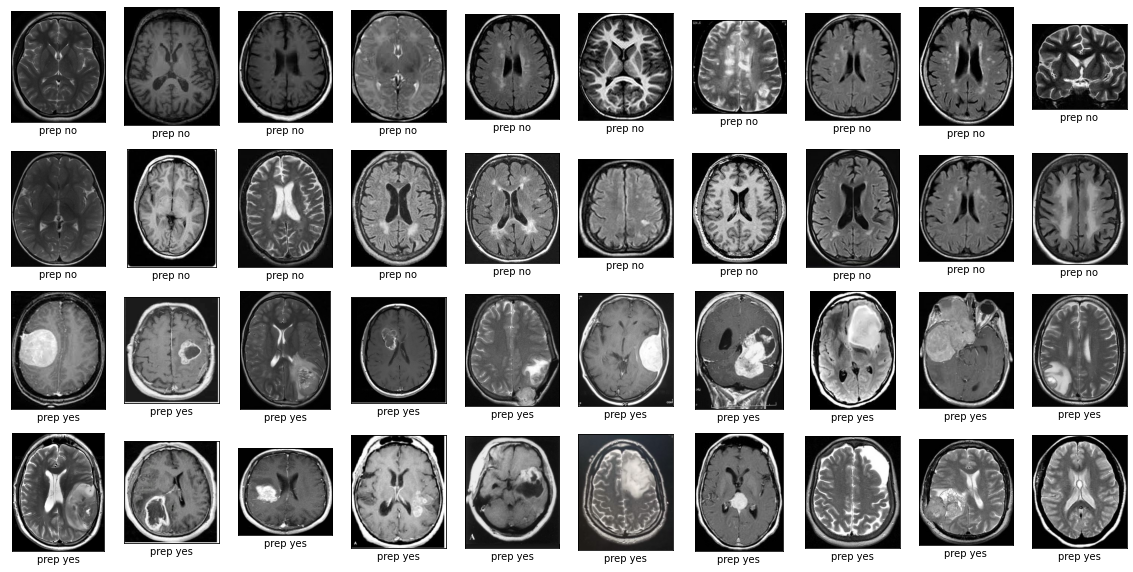

In [11]:
# Plot preprocessed images
plot_samples(prep_imgs_path, 20)

The cropping is not perfect due to some noise in images and low quality of pictures but it is good enough for normalizing the width and height ratios.

## Data Loading

In [15]:
# Data augmentation and normalization for training 
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC), 
        transforms.RandomAutocontrast(),
        transforms.ColorJitter(brightness=(0.1, 1.5)), 
        transforms.RandomRotation(15), 
        transforms.RandomHorizontalFlip(), 
        transforms.RandomVerticalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224), 
        interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
                              
train_dataset = torchvision.datasets.ImageFolder(prep_imgs_path, 
                  data_transforms['train'])
val_dataset = torchvision.datasets.ImageFolder(prep_imgs_path, 
                data_transforms['val'])

# Create the index splits for training and validation
train_size = 0.8
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
np.random.shuffle(indices)
train_idx, val_idx = indices[:split], indices[split:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=val_idx)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=True)

In [16]:
print('Number of training examples: {len_train}\n'
      'Number of validation examples: {len_val}'
      .format(len_train = len(train_data), len_val = len(val_data)))

Number of training examples: 202
Number of validation examples: 51


Let's check a distribution of our both classes across training and validation set.

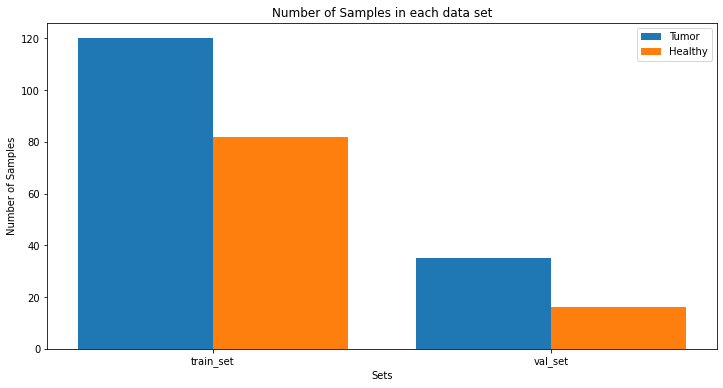

In [17]:
plt.figure(figsize=(12, 6))

X = ['train_set', 'val_set']
train_data_no = [sample for sample in train_data if sample[1] == 0]
val_data_no = [sample for sample in val_data if sample[1] == 0]
train_data_yes = [sample for sample in train_data if sample[1] == 1]
val_data_yes = [sample for sample in val_data if sample[1] == 1]

healthy = [len(train_data_no), len(val_data_no)]
tumor = [len(train_data_yes), len(val_data_yes)]

X_axis = np.arange(len(X))

plt.bar(X_axis - 0.2, tumor, 0.4, label = 'Tumor')
plt.bar(X_axis + 0.2, healthy, 0.4, label = 'Healthy')

plt.xticks(X_axis, X)
plt.xlabel("Sets")
plt.ylabel("Number of Samples")
plt.title("Number of Samples in each data set")
plt.legend()
plt.show()

As we can see data are distributed proportionally to train and validation sets. We can also notice that we have less healthy than tumorous images.

## Model Building

I will split this part into two segments. 
First, I will define simple CNN architecture on my own and train it.
Then, I will use Transfer Learning on pre-trained VGG-16 net to obtain optimal results


Before I start building my model, I define training and validation loops. I put them together into fit_model() function which will initialize learning of our models.

In [18]:
def train(model, dataloader, loss_fn, optimizer):
    """ 
    Defines single training epoch. 
    Returns the average training set loss and accuracy for that epoch.
    """
    size = len(dataloader.dataset)
    model.train()
    total_loss, acc = 0, 0
    for batch, (inputs, labels) in enumerate(dataloader):
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        
        # Compute prediction error
        output = model(inputs)
        labels = labels.unsqueeze(1)
        labels = labels.float()
        loss = loss_fn(output, labels)
        total_loss += loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        predictions = output >= 0.5
        acc += (predictions==labels).sum()

    return total_loss.item()/size, acc.item()/size


def validate(model, dataloader, loss_fn):
    """ 
    Returns the average validation set loss,
    and accuracy for a single epoch.
    """
    size = len(dataloader.dataset)
    model.eval()
    loss, acc = 0, 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()

            output = model(inputs)
            labels = labels.unsqueeze(1)
            labels = labels.float()
            loss += loss_fn(output, labels)

            predictions = output >= 0.5
            acc += (predictions==labels).sum()
    
    return loss.item()/size, acc.item()/size


def fit_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=10):
    """ 
    Initializes model learning. Returns a dictionary with the average 
    training loss/accuracy, and validation loss/accuracy for each epoch.
    """
    hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    for epoch in range(1, epochs + 1):
        tl, ta = train(model, train_loader, loss_fn, optimizer)
        vl, va = validate(model, val_loader, loss_fn)
        if epoch % 10 == 0:
            print('Epoch {:d}, Train acc={:3f}, Val acc={:3f}, Train loss={:3f}, '
                  'Val loss={:3f}'.format(epoch, ta, va, tl, vl))
        hist['train_loss'].append(tl)
        hist['train_acc'].append(ta)
        hist['val_loss'].append(vl)
        hist['val_acc'].append(va)
    return hist

Let's also define a simple function for plotting model's loss and accuracy changes during the learning.

In [19]:
def plot_loss_acc(hist):
    """ Plots accuracy and loss metrics over epochs. """
    plt.figure(figsize=(15,5))

    # Accuracy
    plt.subplot(121)
    plt.plot(hist['train_acc'], label='Training acc')
    plt.plot(hist['val_acc'], label='Validation acc')
    plt.legend()

    # Loss
    plt.subplot(122)
    plt.plot(hist['train_loss'], label='Training loss')
    plt.plot(hist['val_loss'], label='Validation loss')
    plt.legend()

    plt.show()

### My Model

With such a small dataset as we have it's impossible to train a deep learning model from scratch and obtain reasonable results. This is the reason why, I will utilize Transfer Learning later on. However, I'll try to build a small model first and train it on our data to see how well it does.

In [20]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4),
            nn.MaxPool2d(kernel_size=4),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(5408, 1)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 5408)
        x = self.classifier(x)
        return x

In [21]:
# Check if GPU accelerator is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [22]:
model = MyModel().to(device)
summary(model, input_size=(1,3,224,224))

C:\Users\Igor Kolasa\Python\Python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  --                        --
├─Sequential: 1-1                        [1, 32, 13, 13]           --
│    └─Conv2d: 2-1                       [1, 32, 218, 218]         4,736
│    └─ReLU: 2-2                         [1, 32, 218, 218]         --
│    └─MaxPool2d: 2-3                    [1, 32, 54, 54]           --
│    └─MaxPool2d: 2-4                    [1, 32, 13, 13]           --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Dropout: 2-5                      [1, 5408]                 --
│    └─Linear: 2-6                       [1, 1]                    5,409
Total params: 10,145
Trainable params: 10,145
Non-trainable params: 0
Total mult-adds (M): 225.08
Input size (MB): 0.60
Forward/backward pass size (MB): 12.17
Params size (MB): 0.04
Estimated Total Size (MB): 12.81

In [23]:
loss_fn = nn.BCEWithLogitsLoss()
l_rate = 0.0001
optimizer = torch.optim.RMSprop(model.parameters(), lr=l_rate)

In [24]:
hist = fit_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=200)

Epoch 10, Train acc=0.564356, Val acc=0.588235, Train loss=0.040049, Val loss=0.042457
Epoch 20, Train acc=0.673267, Val acc=0.568627, Train loss=0.036188, Val loss=0.038766
Epoch 30, Train acc=0.698020, Val acc=0.745098, Train loss=0.035724, Val loss=0.039652
Epoch 40, Train acc=0.673267, Val acc=0.823529, Train loss=0.034322, Val loss=0.033147
Epoch 50, Train acc=0.698020, Val acc=0.607843, Train loss=0.035507, Val loss=0.033805
Epoch 60, Train acc=0.707921, Val acc=0.823529, Train loss=0.031679, Val loss=0.031011
Epoch 70, Train acc=0.752475, Val acc=0.843137, Train loss=0.031186, Val loss=0.032654
Epoch 80, Train acc=0.702970, Val acc=0.862745, Train loss=0.034366, Val loss=0.046008
Epoch 90, Train acc=0.787129, Val acc=0.686275, Train loss=0.031097, Val loss=0.038379
Epoch 100, Train acc=0.747525, Val acc=0.686275, Train loss=0.030705, Val loss=0.034727
Epoch 110, Train acc=0.797030, Val acc=0.686275, Train loss=0.027444, Val loss=0.036090
Epoch 120, Train acc=0.777228, Val acc=0.

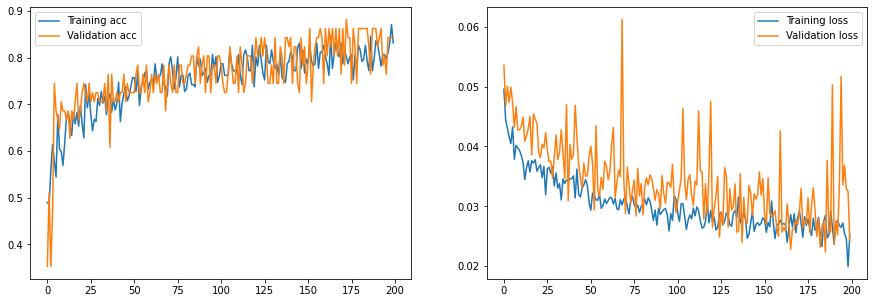

In [19]:
plot_loss_acc(hist)

We obtained over 81% accuracy on the training set and over 84% accuracy on the validation set.

### Transfer Learning

As mentioned earlier, it is recommended to use a Transfer Learning technique for such a small dataset we have. I will use VGG-16 network pretrained on ImageNet dataset.

In [30]:
vgg = torchvision.models.vgg16(pretrained=True)
vgg.to(device)
summary(vgg, input_size=(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         1,792
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         36,928
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        73,856
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        147,584
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]          29

In [31]:
# Replace the final classifier with the one
# that will produce the required number of classes
new_classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Linear(25088, 1),
)
vgg.classifier = new_classifier.to(device) 

# Freeze weights of convolutional feature extractor
for x in vgg.features.parameters():
    x.requires_grad = False

summary(vgg, (1, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      --                        --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 224, 224]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 224, 224]         --
│    └─Conv2d: 2-3                       [1, 64, 224, 224]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 224, 224]         --
│    └─MaxPool2d: 2-5                    [1, 64, 112, 112]         --
│    └─Conv2d: 2-6                       [1, 128, 112, 112]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 112, 112]        --
│    └─Conv2d: 2-8                       [1, 128, 112, 112]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 112, 112]        --
│    └─MaxPool2d: 2-10                   [1, 128, 56, 56]          --
│    └─Conv2d: 2-11                      [1, 256, 56, 56]    

In [32]:
loss_fn = nn.BCEWithLogitsLoss()
l_rate = 0.0001
optimizer = torch.optim.RMSprop(vgg.parameters(), lr=l_rate)

In [33]:
hist = fit_model(vgg, train_loader, val_loader, optimizer, loss_fn, epochs=200)

Epoch 10, Train acc=0.910891, Val acc=0.686275, Train loss=0.018464, Val loss=0.030749
Epoch 20, Train acc=0.920792, Val acc=0.745098, Train loss=0.014255, Val loss=0.031989
Epoch 30, Train acc=0.920792, Val acc=0.862745, Train loss=0.013114, Val loss=0.020237
Epoch 40, Train acc=0.940594, Val acc=0.784314, Train loss=0.011256, Val loss=0.028118
Epoch 50, Train acc=0.960396, Val acc=0.803922, Train loss=0.008991, Val loss=0.021660
Epoch 60, Train acc=0.950495, Val acc=0.823529, Train loss=0.007933, Val loss=0.018501
Epoch 70, Train acc=0.965347, Val acc=0.843137, Train loss=0.007007, Val loss=0.024883
Epoch 80, Train acc=0.985149, Val acc=0.843137, Train loss=0.005782, Val loss=0.019604
Epoch 90, Train acc=0.950495, Val acc=0.823529, Train loss=0.006542, Val loss=0.017386
Epoch 100, Train acc=0.960396, Val acc=0.882353, Train loss=0.006712, Val loss=0.020864
Epoch 110, Train acc=0.975248, Val acc=0.843137, Train loss=0.005872, Val loss=0.019708
Epoch 120, Train acc=0.975248, Val acc=0.

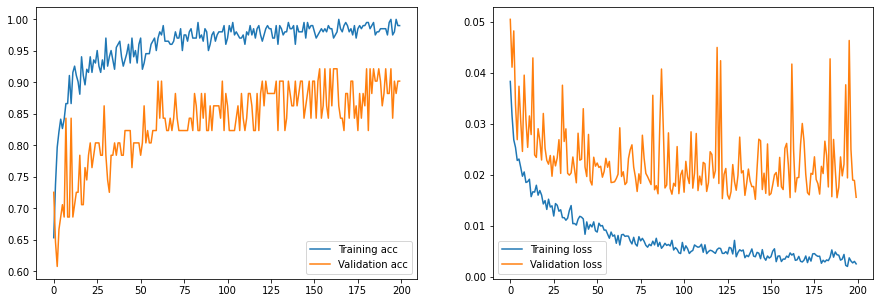

In [34]:
plot_loss_acc(hist)

We obtained 99% accuracy on the training set and over 90% accuracy on the validation set.

The validation loss is about two times lower than the validation loss we get from the previous model.